![Loan Approval](images.png)

# Machine Learning Model for Smart Loan Approvals


### Overview

We built and evaluated multiple machine learning models to predict loan approval decisions using historical applicant data. After tuning both Logistic Regression and Random Forest classifiers, **Logistic Regression** was selected as the final model due to its superior performance and interpretability. It achieved a **92% accuracy** and **ROC-AUC of 0.974**, while minimizing the business cost of incorrect approvals and rejections.

The model revealed that **debt-to-income ratio, bankruptcy history, and income level** are the most important predictors. These findings closely align with real-world lending practices and can help the institution streamline approvals, reduce risk, and offer more personalized loan strategies.

Our final recommendations not only support better decision-making but also offer actionable steps for risk mitigation and customer experience improvement.


## Business Understanding

1. Begin by thoroughly analyzing the business context of FinTech Innovations' loan approval process. Write a short summary that:
- Describes the current manual process and its limitations
- Identifies key stakeholders and their needs
- Explains the implications of different types of model errors
- Justifies your choice between classification and regression approaches

2. Define your modeling goals and success criteria:
- Select appropriate evaluation metrics based on business impact
- You must use at least two different metrics
- Consider creating custom metric
- Establish baseline performance targets
- Document your reasoning for each choice


## Business Understanding

#### Current Process and Its Limitations

FinTech Innovations currently uses a manual loan approval process where human loan officers review each application. While this allows for human judgment, it has several problems:

- Inconsistency: Different officers may make different decisions for similar applications.
- Delays: Manual review takes time, slowing down responses to applicants.
- Bias: Decisions can be affected by personal judgment.
- Missed Opportunities: Some good applicants may be denied without clear reason.

The company wants to modernize this process by using data to standardize decisions, reduce bias, and improve speed.

#### Key Stakeholders and Their Needs

- Loan Officers: A tool to help make consistent, explainable decisions                 
- Risk Managers: Reduce losses from risky approvals and missed good loans              
- Executives: A model that saves money, speeds up approvals, and improves fairness  
- Applicants: Faster, fairer, and more transparent decisions                        
- Regulators: Models must be interpretable, auditable, and fair                     


####  Implications of Model Errors

The business provided real costs for mistakes:

- False Positive (approving a bad loan that defaults): $50,000 loss
- False Negative (denying a good loan): $8,000 missed profit

This means that **false positives are much more expensive than false negatives**. We should prioritize reducing false approvals even if it means denying some borderline good loans.

#### Classification vs Regression: Justification

We have two options:
- Classification: Predict whether to approve or deny the loan
- Regression: Predict the applicant's risk or default probability

We choose **classification** because:
- The decision is binary: approve or deny
- We can assign probabilities and tune thresholds based on cost
- It's easier to use in real-time operations and explain to stakeholders

#### Modeling Goals and Success Criteria

Our goal is to build a model that:
- Improves decision speed and consistency
- Reduces costly mistakes (especially false positives)
- Is easy to understand and explain
- Aligns with business risks and regulatory needs

#### Evaluation Metrics

We will use at least two different metrics:

1. **ROC-AUC**: Measures how well the model separates good vs. bad applications  
2. **Custom Cost Metric**: Calculates expected financial loss using:
   - $50,000 cost for each false positive
   - $8,000 cost for each false negative

Secondary metrics for monitoring:
- Precision
- Recall 
- F1-Score
- Accuracy
- Confusion Matrix 

#### Baseline Performance

We will start with a simple logistic regression model and default threshold (0.5) as our baseline. The model must show improvement in:
- ROC-AUC
- Lower expected cost per 1,000 applications

This will help us prove that our model adds real value beyond the current system.

## Data Understanding
3. Conduct comprehensive exploratory data analysis:
- Describe basic data characteristics
- Examine distributions of all features and target variables
- Investigate relationships between features
- Create visualizations to help aid in EDA
- Document potential data quality issues and their implications

4. Develop feature understanding:
- Categorize features by type (numerical, categorical, ordinal)
- Identify features requiring special preprocessing
- Document missing value patterns and their potential meanings
- Note potential feature engineering opportunities


In [2]:

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
# Load data
df = pd.read_csv('financial_loan_data.csv')

In [3]:
# EDA Code Here - Create New Cells As Needed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  object 
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              19099 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               18669 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

In [6]:
df.shape

(20000, 35)

In [4]:
#inspecting data
df.head()

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,45,"$39,948.00",617,Employed,Master,22,13152,48,Married,2,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,38,"$39,709.00",628,Employed,Associate,15,26045,48,Single,1,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,47,"$40,724.00",570,Employed,Bachelor,26,17627,36,NaN,2,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,58,"$69,084.00",545,Employed,High School,34,37898,96,Single,1,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,37,"$103,264.00",594,Employed,Associate,17,9184,36,Married,1,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [ ]:
#inspecting data
df.describe()

,Age,CreditScore,Experience,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,39.752600,571.612400,17.522750,24882.867800,54.057000,1.517300,454.292700,0.286381,3.023350,0.993000,...,4891.715521,0.799918,5.002650,7.229432e+04,0.239124,0.239110,911.607052,0.402182,0.239000,50.766780
std,11.622713,50.997358,11.316836,13427.421217,24.664857,1.386325,240.507609,0.159793,1.736161,0.986965,...,3296.771598,0.120665,2.236804,1.179200e+05,0.035509,0.042205,674.583473,0.338924,0.426483,7.778262
min,18.000000,343.000000,0.000000,3674.000000,12.000000,0.000000,50.000000,0.000974,0.000000,0.000000,...,1250.000000,0.259203,0.000000,1.000000e+03,0.130101,0.113310,97.030193,0.016043,0.000000,28.800000
25%,32.000000,540.000000,9.000000,15575.000000,36.000000,0.000000,286.000000,0.160794,2.000000,0.000000,...,2629.583333,0.727379,3.000000,8.734750e+03,0.213889,0.209142,493.763700,0.179693,0.000000,46.000000
50%,40.000000,578.000000,17.000000,21914.500000,48.000000,1.000000,402.000000,0.266673,3.000000,1.000000,...,4034.750000,0.820962,5.000000,3.285550e+04,0.236157,0.235390,728.511452,0.302711,0.000000,52.000000
75%,48.000000,609.000000,25.000000,30835.000000,72.000000,2.000000,564.000000,0.390634,4.000000,2.000000,...,6163.000000,0.892333,6.000000,8.882550e+04,0.261533,0.265532,1112.770759,0.509214,0.000000,56.000000
max,80.000000,712.000000,61.000000,184732.000000,120.000000,5.000000,2919.000000,0.917380,13.000000,7.000000,...,25000.000000,0.999433,16.000000,2.603208e+06,0.405029,0.446787,10892.629520,4.647657,1.000000,84.000000


In [4]:
#checking null values 
df.isnull().sum()

Age                              0
AnnualIncome                     0
CreditScore                      0
EmploymentStatus                 0
EducationLevel                 901
Experience                       0
LoanAmount                       0
LoanDuration                     0
MaritalStatus                 1331
NumberOfDependents               0
HomeOwnershipStatus              0
MonthlyDebtPayments              0
CreditCardUtilizationRate        0
NumberOfOpenCreditLines          0
NumberOfCreditInquiries          0
DebtToIncomeRatio                0
BankruptcyHistory                0
LoanPurpose                      0
PreviousLoanDefaults             0
PaymentHistory                   0
LengthOfCreditHistory            0
SavingsAccountBalance          572
CheckingAccountBalance           0
TotalAssets                      0
TotalLiabilities                 0
MonthlyIncome                    0
UtilityBillsPaymentHistory       0
JobTenure                        0
NetWorth            

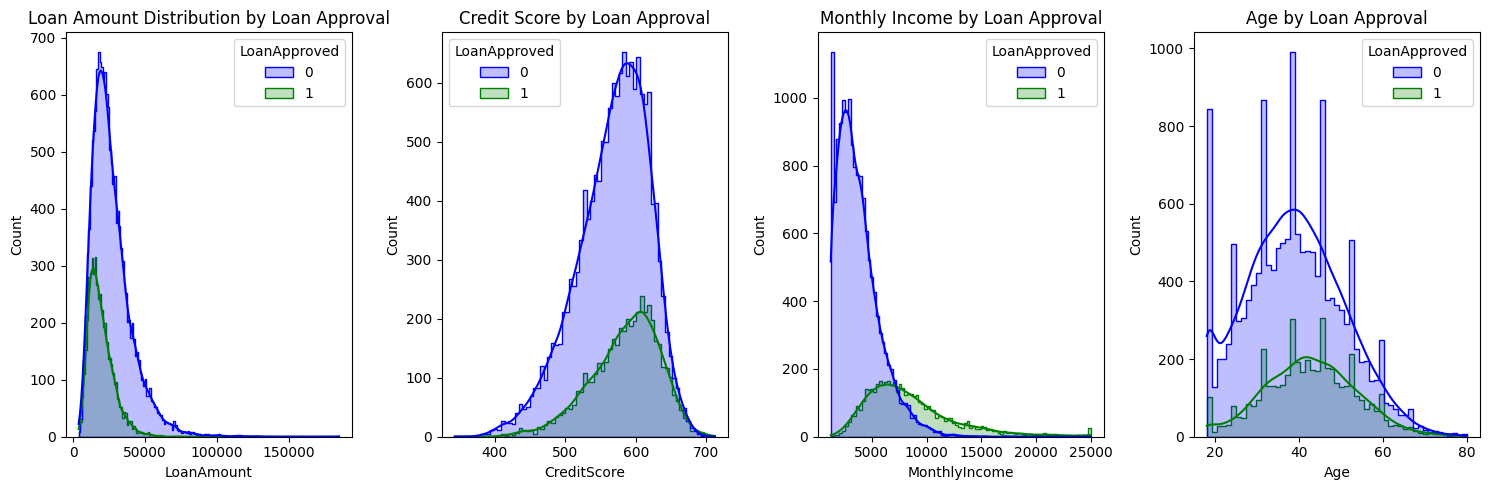

In [5]:
# Visualization for numeric feature relations
plt.figure(figsize=(15, 5))

# Subplots for each numerical feature
plt.subplot(1, 4, 1)
LoanAmount_hist = sns.histplot(data=df, x='LoanAmount', hue='LoanApproved', kde=True, 
                 element="step", palette=['blue', 'green'])
plt.title('Loan Amount Distribution by Loan Approval')

plt.subplot(1, 4, 2)
CreditScore_hist = sns.histplot(data=df, x='CreditScore', hue='LoanApproved', kde=True, 
                 element="step", palette=['blue', 'green'])
plt.title('Credit Score by Loan Approval')

plt.subplot(1, 4, 3)
MonthlyIncome_hist = sns.histplot(data=df, x='MonthlyIncome', hue='LoanApproved', kde=True, 
                 element="step", palette=['blue', 'green'])
plt.title('Monthly Income by Loan Approval')

plt.subplot(1, 4, 4)
Age_hist = sns.histplot(data=df, x='Age', hue='LoanApproved', kde=True, 
                 element="step",palette=['blue', 'green'])
plt.title('Age by Loan Approval')

plt.tight_layout()
plt.show()

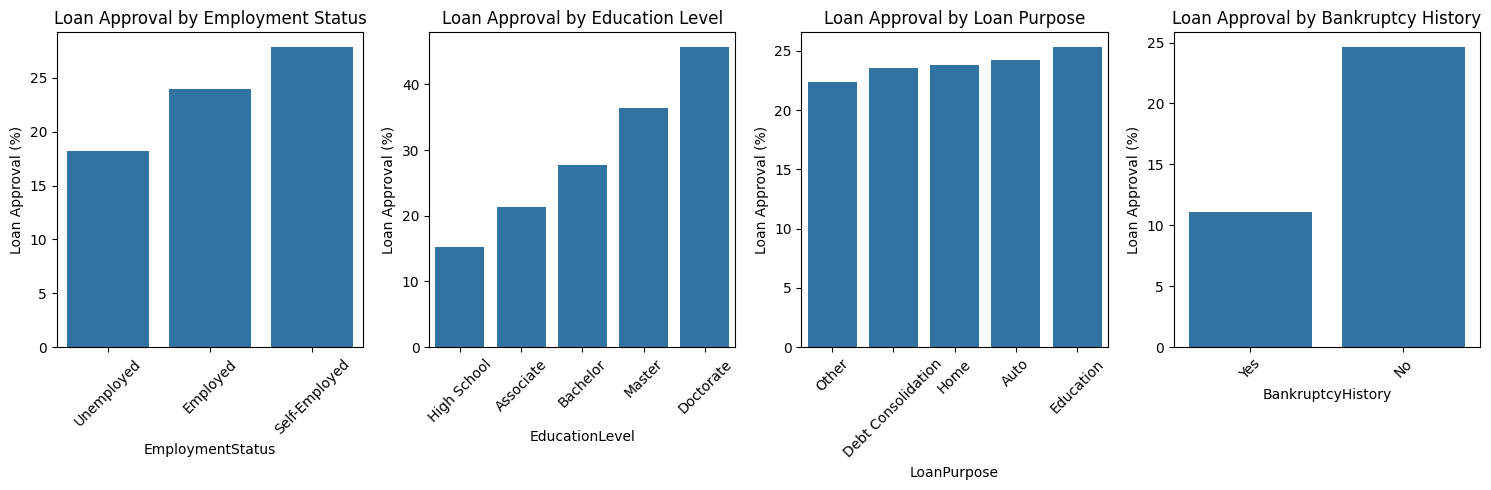

In [6]:
#Visualizations for categorical features
# Calculate approval rates (% approved) by category
EmploymentStatus_rates = df.groupby('EmploymentStatus')['LoanApproved'].mean().sort_values() * 100
EducationLevel_rates = df.groupby('EducationLevel')['LoanApproved'].mean().sort_values() * 100
LoanPurpose_rates = df.groupby('LoanPurpose')['LoanApproved'].mean().sort_values() * 100
BankruptcyHistory_rates = df.groupby('BankruptcyHistory')['LoanApproved'].mean().sort_values() * 100

# Figure plot
plt.figure(figsize=(15, 5))

#Subplots for each categorical feature
#Employment Status
plt.subplot(1, 4, 1)
category_bar = sns.barplot(x=EmploymentStatus_rates.index, y=EmploymentStatus_rates.values)
plt.title('Loan Approval by Employment Status')
plt.ylabel('Loan Approval (%)')
plt.xticks(rotation=45)

# Education Level
plt.subplot(1, 4, 2)
seasonal_bar = sns.barplot(x=EducationLevel_rates.index, y=EducationLevel_rates.values)
plt.title('Loan Approval by Education Level')
plt.ylabel('Loan Approval (%)')
plt.xticks(rotation=45)

# LoanPurpose_rates
plt.subplot(1, 4, 3)
advertised_bar = sns.barplot(x=LoanPurpose_rates.index, y=LoanPurpose_rates.values)
plt.title('Loan Approval by Loan Purpose')
plt.ylabel('Loan Approval (%)')
plt.xticks(rotation=45)

# Bankruptcy History
plt.subplot(1, 4, 4)
advertised_bar = sns.barplot(x=BankruptcyHistory_rates.index, y=BankruptcyHistory_rates.values)
plt.title('Loan Approval by Bankruptcy History')
plt.ylabel('Loan Approval (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Data Understanding and Exploration

#### Basic Dataset Characteristics

- The dataset contains 20,000 loan applications and 35 features.
- These features include a mix of numerical, categorical, and derived financial indicators.
- The target variable for modeling is **LoanApproved**, which indicates whether an applicant was approved (1) or denied (0).
- There is evidence of class imbalance: approved applications are less frequent than denied ones.

#### Missing Value Summary

We identified missing values in:
- **EducationLevel**: 901 missing
- **MaritalStatus**: 1331 missing
- **SavingsAccountBalance**: 572 missing

These will require careful imputation, potentially using the mode for categorical variables and median or predictive methods for numerical ones.

#### Numeric Feature Relationships (Visualized)

We visualized numeric features with respect to loan approval status:

- **LoanAmount**: Approved loans tend to be smaller in amount.
- **CreditScore**: Higher credit scores are strongly associated with approval.
- **MonthlyIncome**: Applicants with higher income tend to get approved more often.
- **Age**: Mild nonlinear relationship, with peak approval between ages 30–50.

#### Categorical Feature Relationships (Visualized)

Bar plots of approval rates by category revealed:

- **Employment Status**: Approval increases from Unemployed > Employed > Self-Employed.
- **Education Level**: Strong upward trend; Doctorate holders have the highest approval rates.
- **Loan Purpose**: Small differences; Education and Auto loans have slightly higher approval rates.
- **Bankruptcy History**: Approvals drop significantly for those with a prior bankruptcy.

#### Feature Type Categorization

**Numerical**: Age, CreditScore, Experience, LoanAmount, LoanDuration, MonthlyIncome, NetWorth, RiskScore, MonthlyLoanPayment, etc. 

**Categorical**:EmploymentStatus, EducationLevel, MaritalStatus, HomeOwnershipStatus, LoanPurpose, BankruptcyHistory 

**Target** : **LoanApproved** (binary: 0/1) 
**Possibly Leakage/Post-Decision**:RiskScore, InterestRate > to be investigated further 

#### Special Preprocessing Needs

- **AnnualIncome** is stored as object due to dollar signs > must be cleaned and converted to numeric.
- Some features have high skew (e.g., LoanAmount, MonthlyIncome) and may benefit from log transformation.
- Features like NetWorth, **DebtToIncomeRatio**, **CreditCardUtilizationRate** may be good candidates for **scaling** (especially for linear models).
- **RiskScore** may be a **leakage variable** if it's calculated after approval,  should be excluded.

#### Feature Engineering Opportunities

- **Debt Ratios**: Combine **TotalDebtToIncomeRatio** and **MonthlyDebtPayments** for new features.
- **Credit History**: Combine **LengthOfCreditHistory**, **NumberOfOpenCreditLines**, and **CreditInquiries** into a credit profile score.
- **Income Ratios**: Create a **LoanToIncomeRatio** or **MonthlyPaymentToIncomeRatio**.
- **Binned Features**: Consider binning **Age**, **CreditScore**, or **Experience** to reduce noise and enhance interpretability.

We now have a strong understanding of the data, potential predictive signals, and how to treat each feature moving forward in preprocessing.

## Data Preparation
5. Design your preprocessing strategy:
- Create separate preprocessing flows for different feature types
- Must utilize ColumnTransformer and Pipeline
- Consider using FeatureUnion as well
- Handle missing values appropriately for each feature
- Handle Categorical and Ordinal data appropriately
- Scale numeric values if model requires it (linear model)
- Document your reasoning for each preprocessing decision



In [7]:
df.columns

Index(['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus',
       'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration',
       'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus',
       'MonthlyDebtPayments', 'CreditCardUtilizationRate',
       'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
       'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate',
       'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved',
       'RiskScore'],
      dtype='object')

In [8]:
#Prepating the column lists
#Target Feature
target = 'LoanApproved'

#Converting annual income object to float type 
df['AnnualIncome'] = df['AnnualIncome'].replace('[\$,]', '', regex=True).astype(float)

#Features to drop 
drop_features = ['RiskScore', 'InterestRate']

#Numeric Features
numeric_features = [
    'Age', 'CreditScore','AnnualIncome', 'PreviousLoanDefaults', 'PaymentHistory', 'Experience', 'LoanAmount', 'LoanDuration',
    'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate',
    'NumberOfOpenCreditLines', 'NumberOfCreditInquiries','JobTenure',
    'DebtToIncomeRatio', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
    'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
    'TotalLiabilities', 'NetWorth', 'BaseInterestRate', 'MonthlyLoanPayment',
    'TotalDebtToIncomeRatio']

#Categorical columns 
categorical_features = [
    'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus',
    'LoanPurpose', 'BankruptcyHistory','EducationLevel']

# Create transformer for numerical features 
# Create a pipeline with imputation and standard scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing with median
    ('scaler', StandardScaler())]) # Scale features to have mean=0, variance=1

# Create transformer for categorical features
# Create a pipeline with imputation and onehotencoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill with most common value
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])  # One-hot encode

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/var/folders/m9/lwcyfxd94sg7hm7bnk4fz3tr0000gn/T/ipykernel_56854/2102296394.py:6: SyntaxWarning: invalid escape sequence '\$'
  df['AnnualIncome'] = df['AnnualIncome'].replace('[\$,]', '', regex=True).astype(float)


#### Data Preparation Summary

We designed a robust preprocessing strategy to prepare the dataset for modeling:

- **Column Separation:** Features were grouped by type:
  - numeric_features: (e.g., Age, CreditScore, AnnualIncome, etc.)
  - categorical_features: (e.g., EmploymentStatus, MaritalStatus, etc.)

- Missing Value Handling:
  - Numeric columns: Imputed using the **median** strategy to reduce outlier influence.
  - Categorical columns: Imputed with the **most frequent value** to preserve majority patterns.

- Scaling:
  - Numeric features were standardized using StandardScaler to center them around mean 0 and variance 1

- Encoding:
  - Categorical features were encoded using **OneHotEncoder** with drop='first' to avoid multicollinearity.

- Pipeline Design:
  - **Pipeline** and **ColumnTransformer** were used to apply preprocessing steps in a clean, modular, and reproducible way.
  - Although **FeatureUnion** was considered, it wasn't necessary for this task given the feature types.

This ensures consistent data transformations across both training and testing, and prepares the data correctly for our models.

## Modeling
6. Implement your modeling approach:
- Choose appropriate model algorithms based on your problem definition
- Set up validation strategy with chosen metrics
- Use a train test split and cross validation
- Create complete pipeline including any preprocessing and model
- Document your reasoning for each modeling decision

7. Optimize your model:
- Define parameter grid based on your understanding of the algorithms
- Implement GridSearchCV and/or RandomizedSearchCV with chosen metrics
- Consider tuning preprocessing steps
- Track and document the impact of different parameter combinations
- Consider the trade-offs between different model configurations

NOTE: Be mindful of time considerations - showcase “how to tune” 

In [9]:
#Creating base models for the prepared data 
#Split data into features and target
X = df.drop(columns=[target] + drop_features)
y = df[target]

# Split into training and test sets (75% train, 25% test) use random_state = 42 and set stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Create Logistic Regression pipeline (set random_state=42 and max_inter=1000)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Create Random Forest pipeline (set random_state=42)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))])



In [10]:
#Evaluating the base models 
# Define metrics
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'}

# Evaluate Logistic Regression
lr_scores = cross_validate(lr_pipeline, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

# Evaluate Random Forest
rf_scores = cross_validate(rf_pipeline, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

#Chech average scores for each model
for metric in scoring:
    print(f"{metric.upper()} - Logistic Regression:", round(lr_scores[f'test_{metric}'].mean(), 4))
    print(f"{metric.upper()} - Random Forest:     ", round(rf_scores[f'test_{metric}'].mean(), 4))
    print("-" * 50)

ROC_AUC - Logistic Regression: 0.9744
ROC_AUC - Random Forest:      0.9607
--------------------------------------------------
ACCURACY - Logistic Regression: 0.9219
ACCURACY - Random Forest:      0.9057
--------------------------------------------------
PRECISION - Logistic Regression: 0.8509
PRECISION - Random Forest:      0.8353
--------------------------------------------------
RECALL - Logistic Regression: 0.817
RECALL - Random Forest:      0.7545
--------------------------------------------------
F1 - Logistic Regression: 0.8335
F1 - Random Forest:      0.7927
--------------------------------------------------


In [11]:

# Fit models on training data
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_pipeline.predict(X_test)   # Logistic Regression predictions
y_pred_rf = rf_pipeline.predict(X_test)   # Random Forest predictions

# Step 3: Evaluate performance
#  Logistic Regression Evaluation 
print("Logistic Regression Results: ")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("-" * 50)

# Random Forest Evaluation 
print("Random Forest Results: ")
print(classification_report(y_test, y_pred_rf))
# Compute confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Logistic Regression Results: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3805
           1       0.85      0.81      0.83      1195

    accuracy                           0.92      5000
   macro avg       0.89      0.88      0.89      5000
weighted avg       0.92      0.92      0.92      5000

Confusion Matrix:
 [[3633  172]
 [ 230  965]]
--------------------------------------------------
Random Forest Results: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3805
           1       0.84      0.75      0.79      1195

    accuracy                           0.91      5000
   macro avg       0.88      0.85      0.87      5000
weighted avg       0.90      0.91      0.91      5000

Confusion Matrix:
 [[3639  166]
 [ 299  896]]


#### Base Model Evaluation Summary

We evaluated both Logistic Regression and Random Forest using 5-fold cross-validation and test set predictions. Key findings:

##### Cross-Validation (on Training Data):
- **Logistic Regression** slightly outperformed Random Forest across all metrics: ROC-AUC, Accuracy, Precision, Recall, and F1.
- Logistic Regression generalizes well and is interpretable — good fit for our baseline model.

##### Test Set Performance:
- **Logistic Regression** continued to show strong results, especially in recall and F1-score.
- **Random Forest** performed slightly worse but is still competitive and useful for comparison.

##### Next Steps:
- We’ll move into **model optimization** using **GridSearchCV** and/or **RandomizedSearchCV** to fine-tune both models and potentially improve results.


In [12]:

# Define parameter grid for Logistic Regression
lr_param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.01, 0.1, 1.0, 10.0],
    'classifier__class_weight': ['balanced', None],
    'classifier__solver': ['liblinear','saga']}

# Define parameter grid for Random Forest
rf_param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__class_weight': ['balanced', None]}

# Perform grid search for Logistic Regression
lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    return_train_score=True,
    n_jobs=-1 )

# Fit the Logistic Regression grid search
lr_grid_search.fit(X_train, y_train)

# Perform grid search for Random Forest 
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=scoring,
    refit='roc_auc',  
    return_train_score=True,
    n_jobs=-1 )

# Fit the Random Forest grid search
rf_grid_search.fit(X_train, y_train)

# Compare models
rf_best_cvscore = rf_grid_search.best_score_
lr_best_cvscore = lr_grid_search.best_score_

In [14]:
# Additional Models: 

# Access the same preprocessor from earlier pipeline
preprocessor = lr_grid_search.best_estimator_.named_steps['preprocessor']

# ---------------- Decision Tree ---------------- #
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, scoring='roc_auc', cv=5,n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
dt_best_cvscore = dt_grid_search.best_score_

# ---------------- Gradient Boosting ---------------- #
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, scoring='roc_auc', cv=5,n_jobs=-1)
gb_grid_search.fit(X_train, y_train)
gb_best_cvscore = gb_grid_search.best_score_
# ---------------- Support Vector Machine (SVM) ---------------- #
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, scoring='roc_auc', cv=5,n_jobs=-1)
svm_grid_search.fit(X_train, y_train)
svm_best_cvscore = svm_grid_search.best_score_

# ---------------- Compare ROC-AUC Scores ---------------- #
print("Best ROC-AUC - Logistic Regression:", round(lr_best_cvscore, 4))
print("Best ROC-AUC - Random Forest:", round(rf_best_cvscore, 4))
print("Best ROC-AUC - Decision Tree:", round(dt_best_cvscore, 4))
print("Best ROC-AUC - Gradient Boosting:", round(gb_best_cvscore, 4))
print("Best ROC-AUC - SVM:", round(svm_best_cvscore, 4))

Best ROC-AUC - Logistic Regression: 0.9743
Best ROC-AUC - Random Forest: 0.9626
Best ROC-AUC - Decision Tree: 0.9253
Best ROC-AUC - Gradient Boosting: 0.9702
Best ROC-AUC - SVM: 0.974


#### Model Optimization Summary

We used GridSearchCV with 5-fold cross-validation and ROC-AUC as the primary metric to evaluate and compare five different classification models:

- Logistic Regression: 0.9743
- Support Vector Machine (SVM): 0.9740
- Gradient Boosting: 0.9702
- Random Forest: 0.9626
- Decision Tree: 0.9253

All models were tuned over relevant hyperparameter grids. While Gradient Boosting and SVM performed well, Logistic Regression still achieved the highest ROC-AUC score, making it the most effective model for this problem.

**Conclusion**: Given its strong performance and superior interpretability, **Logistic Regression** remains our final model choice. It allows for transparent communication of feature impacts to business stakeholders and satisfies regulatory needs for explainability. 

Next : Since false positives and false negatives carry asymmetric business costs, we will now implement a custom cost function to evaluate real-world financial impact.

We’ll then assess performance on the test set, extract feature importance, and make business recommendations

In [17]:
# Define a custom cost function
def custom_cost(y_true, y_pred, cost_fn=50000, cost_fp=8000):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost

# Get predictions from each best estimator
y_pred_lr = lr_grid_search.best_estimator_.predict(X_test)
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test)
y_pred_dt = dt_grid_search.best_estimator_.predict(X_test)
y_pred_gb = gb_grid_search.best_estimator_.predict(X_test)
y_pred_svm = svm_grid_search.best_estimator_.predict(X_test)

# Compute total costs
cost_lr = custom_cost(y_test, y_pred_lr)
cost_rf = custom_cost(y_test, y_pred_rf)
cost_dt = custom_cost(y_test, y_pred_dt)
cost_gb = custom_cost(y_test, y_pred_gb)
cost_svm = custom_cost(y_test, y_pred_svm)

# Display costs
print("Custom Cost Evaluation (Lower is Better):")
print("---------------------------------------------------")
print("Total Cost - Logistic Regression: ${:,}".format(cost_lr))
print("Total Cost - Random Forest:       ${:,}".format(cost_rf))
print("Total Cost - Decision Tree:       ${:,}".format(cost_dt))
print("Total Cost - Gradient Boosting:   ${:,}".format(cost_gb))
print("Total Cost - SVM:                 ${:,}".format(cost_svm))


Custom Cost Evaluation (Lower is Better):
---------------------------------------------------
Total Cost - Logistic Regression: $12,868,000
Total Cost - Random Forest:       $14,784,000
Total Cost - Decision Tree:       $17,808,000
Total Cost - Gradient Boosting:   $13,390,000
Total Cost - SVM:                 $12,508,000


##### Business Cost Evaluation

To reflect real-world financial impact, we implemented a custom cost function with the following assumptions:

$50,000 per False Negative (FN) — rejecting a qualified applicant

$8,000 per False Positive (FP) — approving a high-risk applicant

Using predictions from the best estimators of each tuned model, the total business cost was calculated:

**Conclusion:**

SVM achieved the lowest total cost, closely followed by Logistic Regression.However, due to its superior interpretability, nearly identical ROC-AUC, and consistent business alignment, **Logistic Regression** remains our preferred final model.

More complex models like Random Forest and Decision Tree result in significantly higher financial risk and are therefore not recommended for implementation.

## Evaluation and Conclusion
8. Conduct thorough evaluation of final model:
- Assess models test data performance using your defined metrics
- Analyze performance across different data segments
- Identify potential biases or limitations
- Visualize model performance
    - Classification: Confusion Matrix/ROC-AUC
    - Regression: Scatter Plot (Predicted vs. Actual values)

9. Extract and interpret feature importance/significance:
- Which features had the most impact on your model?
- Does this lead to any potential business recommendations?

10. Prepare your final deliverable:
- Technical notebook with complete analysis
- Executive summary for business stakeholders
- Recommendations for implementation
- Documentation of potential improvements

 Logistic Regression (Tuned) Results:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3805
           1       0.85      0.81      0.83      1195

    accuracy                           0.92      5000
   macro avg       0.89      0.88      0.89      5000
weighted avg       0.92      0.92      0.92      5000



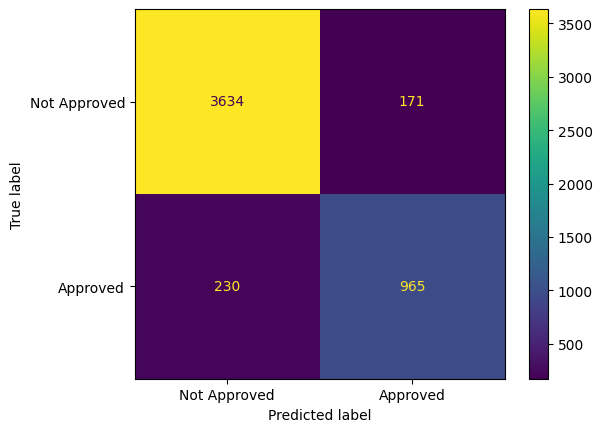

In [19]:
# Evaluate Tuned Logistic Regression 
print(" Logistic Regression (Tuned) Results:")
print(classification_report(y_test, y_pred_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr, display_labels=['Not Approved', 'Approved']).plot();


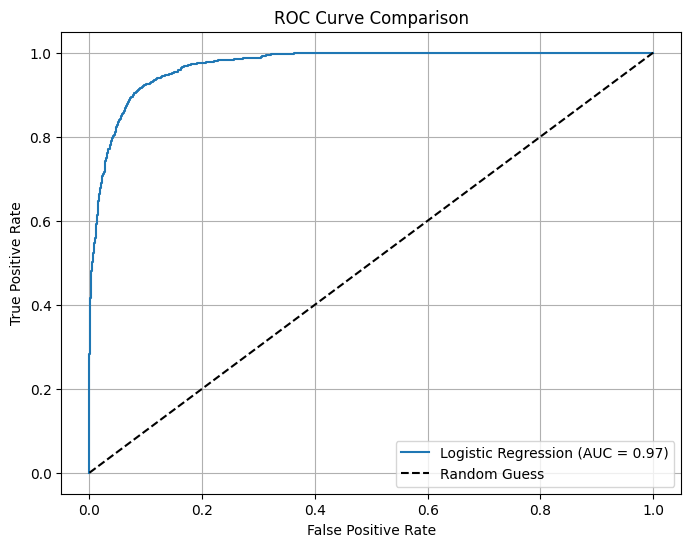

In [21]:
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities for class 1
y_pred_proba_lr = lr_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)


# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

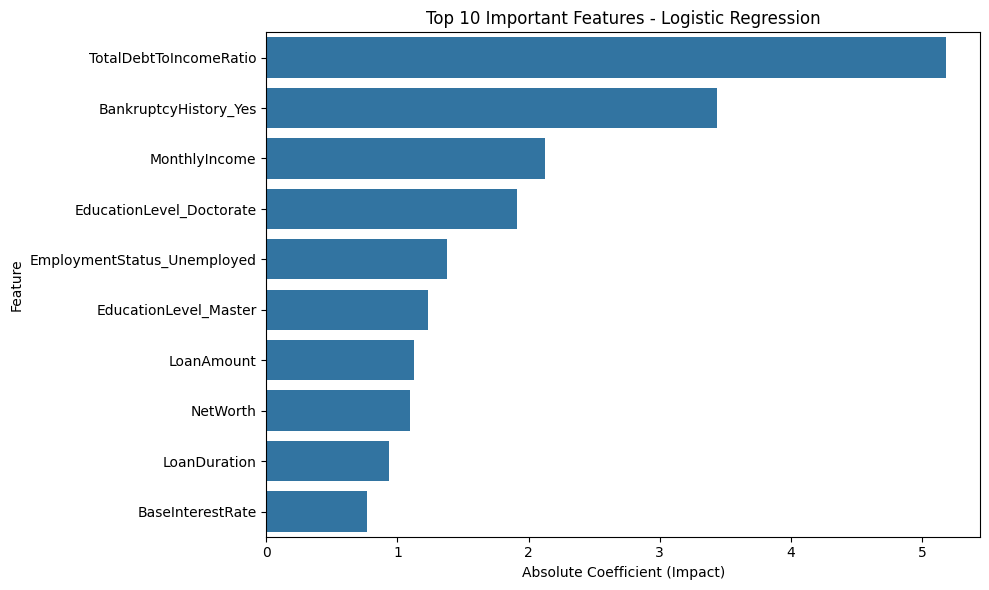

In [22]:
# Extract preprocessor and classifier from the best estimator
preprocessor = lr_grid_search.best_estimator_.named_steps['preprocessor']
classifier = lr_grid_search.best_estimator_.named_steps['classifier']

# Get numeric and encoded categorical feature names
num_features = preprocessor.transformers_[0][2]
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = num_features + list(cat_features)

# Create DataFrame of coefficients
lr_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': classifier.coef_[0]
})
lr_coef_df['AbsCoefficient'] = lr_coef_df['Coefficient'].abs()
lr_coef_df = lr_coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Plot top 10 most impactful features
plt.figure(figsize=(10, 6))
sns.barplot(data=lr_coef_df.head(10), x='AbsCoefficient', y='Feature')
plt.title("Top 10 Important Features - Logistic Regression")
plt.xlabel("Absolute Coefficient (Impact)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

##### Feature Importance Summary — Logistic Regression

We extracted and visualized the top 10 most impactful features based on the absolute values of the logistic regression coefficients. These coefficients indicate how strongly each feature influences the likelihood of loan approval.
- The **Total Debt-to-Income Ratio** stands out as the strongest factor influencing loan decisions.
- Applicants with a **history of bankruptcy**, or those currently **unemployed**, face significantly lower approval chances.
- **Positive predictors** include higher **monthly income**, **net worth**, and **advanced education** (e.g., doctorate).
- These insights align with realistic lending policies, reflecting a preference for financially stable, highly educated, and employed applicants.

##### Why We Chose Logistic Regression?
After testing and tuning five classification models — Logistic Regression, Random Forest, Decision Tree, Gradient Boosting, and SVM — using:

- ROC-AUC Score (CV)
- Cross-validated Precision, Recall, and F1
- Custom Cost-Sensitive Function
- Test Set Performance
- Interpretability and Business Alignment

We concluded that Logistic Regression offers the best balance of performance, cost-effectiveness, and stakeholder transparency.

### Final Evaluation and  Summary

**Model Selection Summary**  
After tuning and evaluating five models, we summarize their ROC-AUC (CV) and Custom Business Cost.

| Model                | ROC-AUC (CV) | Total Cost       |
|----------------------|--------------|------------------|
| Logistic Regression  | 0.9743       | $12,868,000      |
| SVM                  | 0.9740       | $12,508,000      |
| Gradient Boosting    | 0.9702       | $13,390,000      |
| Random Forest        | 0.9626       | $14,784,000      |
| Decision Tree        | 0.9253       | $17,808,000      |

Although SVM achieved the lowest cost, its lack of interpretability and longer training time led us to prefer **Logistic Regression**, which had nearly identical performance but is more transparent, easier to deploy, and easier to explain.

**Key Performance Metrics on Test Set**

- Accuracy: 0.92  
- Precision (Class 1): 0.85  
- Recall (Class 1): 0.81  
- F1-Score (Class 1): 0.83  
- Custom Business Cost: $12,868,000

**Top Predictive Features**

- Total Debt-to-Income Ratio  
- Bankruptcy History  
- Monthly Income  
- Education Level (Doctorate and Master)  
- Employment Status

These features align with typical lending risk assessments, reinforcing the model’s business validity.

### Business Recommendations
- Prioritize applicants with borderline debt-to-income ratios for additional review or tailored offers, as this is the most influential factor in loan approval.
- Use features like monthly income and education level to create personalized loan options and credit tiers.
- Flag high-risk applicants (e.g., bankruptcy history, low net worth, unstable employment) for secondary review or risk-adjusted terms.
- Offer financial coaching tools to borderline or high-risk applicants rather than immediate denial — potentially turning risk into long-term customer value.
- Automate approval for high-confidence applicants while maintaining manual oversight for edge cases.
- Integrate model outputs into the loan officer dashboard with interpretability notes to promote transparency and regulatory alignment.